# Word2vec Tensorflow tutorial

Tutorial based on [https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py] and [https://d2l.ai/chapter_natural-language-processing/word2vec-gluon.html]

In [2]:
from tempfile import gettempdir
import os
import zipfile
import collections
import random

from six.moves import urllib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

## 1. Download and preprocess the data

### 1.1 Download the corpus 

In [3]:
url = 'http://mattmahoney.net/dc/'
filename = 'text8.zip'
local_filename = os.path.join(gettempdir(), filename)
my_file, _ = urllib.request.urlretrieve(url + filename,local_filename)


/tmp/text8.zip


More information about text8 on [http://mattmahoney.net/dc/textdata.html]

In [5]:
with zipfile.ZipFile(my_file) as f:
    print(f.namelist()[0])

text8


In [7]:
with zipfile.ZipFile(my_file) as f:
    corpus = tf.compat.as_str(f.read(f.namelist()[0])).split()

In [8]:
corpus[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

### 1.2 Build the vocabulary

#### Obtain the 50000 most common words in the corpus and the number of times they appear in the corpus

In [13]:
vocabulary_size = 50000
counter = [['UNK', 0]]
counter.extend(collections.Counter(corpus).most_common(vocabulary_size - 1))

In [14]:
print(counter[:10])

[['UNK', 0], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]


#### Assign a numerical id to each word in counter

In [15]:
word_to_index = {}
index_to_word = {}

for i in range(vocabulary_size):
    word_to_index[counter[i][0]] = i
    index_to_word[i] = counter[i][0]

#### Transform the corpus into indices

In [16]:
data = []
for word in corpus:
    index = 0
    if word in word_to_index:
        index = word_to_index[word]
    else:
        counter[0][1]+=1
    data.append(index)

### 1.3 Subsampling frequent words
#### Each word $w_i$ in the training set is discarded with probability computed by the formula:

\begin{equation*}
P(w_i) = 1- \sqrt{\frac{t}{f(w_i)}}
\end{equation*}

where $f(w_i)$ is the frequency of word $w_i$ and $t$ is a chosen threshold, typically around $10^{-5}$

In [9]:
#Set seed for numpy and tensorflow
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)
random.seed(0)

t = pow(10,-4)
#Calculate probabilites
probabilities = {}
#Here: How to explain the max
for word, count in counter:
    probabilities[word] = 1 - max(np.sqrt(t/(float(count)/float(len(corpus)))),0)

def discard(index):
    if np.random.uniform(0,1)<probabilities[index_to_word[index]]:
        return True
    return False

data_subsampled = [index for index in data if not discard(index)]

In [10]:
print(len(data))
print(len(data_subsampled))
print(data.count(word_to_index['the']))
print(data_subsampled.count(word_to_index['the']))
print(data.count(word_to_index['ape']))
print(data_subsampled.count(word_to_index['ape']))

17005207
8352073
1061396
42606
92
92


### 1.4 Get targets and contexts

In [11]:
def get_contexts_targets(data, max_window_size):
    contexts = []
    targets = []
    for i in range(len(data)):
        R = np.random.randint(1,max_window_size + 1)
        context = data[max(0, i-R):min(i+R+1, len(data))]
        context.remove(data[i])
        for j in range(len(context)):
            targets.append(data[i])
            contexts.append(context[j])
    return targets, contexts

In [12]:
my_list = [0,1,2,3,4]
print(get_contexts_targets(my_list, 1))

([0, 1, 1, 2, 2, 3, 3, 4], [1, 0, 2, 1, 3, 2, 4, 3])


In [13]:
all_targets, all_contexts  = get_contexts_targets(data_subsampled, 1)

## 2. Create the graph.

In [14]:
embedding_size = 128
num_sampled = 64

#Create placeholders and variables
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[None,1])

embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
stddev=1.0 / np.sqrt(embedding_size)))

nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

loss = tf.reduce_mean(
                    tf.nn.nce_loss(
                    weights=nce_weights,
                    biases=nce_biases,
                    labels=train_labels,
                    inputs=embed,
                    num_sampled=num_sampled,
                    num_classes=vocabulary_size))
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

## 3. Train the model

In [15]:
batch_size = 128
num_epochs = 3

init = tf.global_variables_initializer()
n_data = len(all_contexts)
num_batches = int(n_data/batch_size)

print("Total steps: %d" %  num_batches)
with tf.Session() as sess:
    # Initialize all variables.
    init.run()
    for epoch in range(num_epochs):
        print("Epoch %d" % (epoch+1))
        all_contexts, all_targets = shuffle(all_contexts, all_targets)
        average_loss = 0
        for i in range(num_batches):
            ini = batch_size*i
            end = min(batch_size*(i+1), n_data)
            batch_contexts = np.asarray(all_contexts[ini:end]).reshape(-1,1)
            batch_targets = np.asarray(all_targets[ini:end])
            sess.run(optimizer, feed_dict={train_inputs: batch_targets, 
                                           train_labels: batch_contexts})
            loss_value = sess.run(loss, feed_dict={train_inputs: batch_targets, 
                                           train_labels: batch_contexts})
            average_loss += loss_value
            if i%1000 == 0:
                average_loss /= 1000
                print("Step: %d, average loss: %0.4f" %  (i, average_loss))
                average_loss = 0
    word_embeddings = sess.run(embeddings)

Total steps: 130501
Epoch 1
Step: 0, average loss: 0.2824
Step: 1000, average loss: 173.7752
Step: 2000, average loss: 101.8096
Step: 3000, average loss: 69.0888
Step: 4000, average loss: 51.0853
Step: 5000, average loss: 39.8309
Step: 6000, average loss: 32.3245
Step: 7000, average loss: 26.6258
Step: 8000, average loss: 21.6665
Step: 9000, average loss: 18.2874
Step: 10000, average loss: 16.3837
Step: 11000, average loss: 13.7124
Step: 12000, average loss: 12.5379
Step: 13000, average loss: 11.5794
Step: 14000, average loss: 9.9565
Step: 15000, average loss: 9.3633
Step: 16000, average loss: 8.5662
Step: 17000, average loss: 8.2348
Step: 18000, average loss: 7.4558
Step: 19000, average loss: 7.1374
Step: 20000, average loss: 6.7561
Step: 21000, average loss: 6.4072
Step: 22000, average loss: 6.1087
Step: 23000, average loss: 5.9949
Step: 24000, average loss: 5.7882
Step: 25000, average loss: 5.7232
Step: 26000, average loss: 5.4908
Step: 27000, average loss: 5.4421
Step: 28000, avera

Step: 109000, average loss: 4.2759
Step: 110000, average loss: 4.2640
Step: 111000, average loss: 4.2650
Step: 112000, average loss: 4.2671
Step: 113000, average loss: 4.2625
Step: 114000, average loss: 4.2723
Step: 115000, average loss: 4.2698
Step: 116000, average loss: 4.2676
Step: 117000, average loss: 4.2663
Step: 118000, average loss: 4.2636
Step: 119000, average loss: 4.2693
Step: 120000, average loss: 4.2683
Step: 121000, average loss: 4.2637
Step: 122000, average loss: 4.2602
Step: 123000, average loss: 4.2611
Step: 124000, average loss: 4.2742
Step: 125000, average loss: 4.2588
Step: 126000, average loss: 4.2584
Step: 127000, average loss: 4.2557
Step: 128000, average loss: 4.2599
Step: 129000, average loss: 4.2567
Step: 130000, average loss: 4.2578
Epoch 3
Step: 0, average loss: 0.0042
Step: 1000, average loss: 4.1669
Step: 2000, average loss: 4.1582
Step: 3000, average loss: 4.1655
Step: 4000, average loss: 4.1704
Step: 5000, average loss: 4.1726
Step: 6000, average loss: 4

## 4. Evaluate the model

### 4.1 Define a similarity function

In [16]:
def cosine_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u*norm_v)
    return cosine_similarity

### 4.2 Find the most similar words to a given word

In [17]:
def most_similar(word, word_embeddings,n):
    index = word_to_index[word]
    cos_similarities = [cosine_similarity(word_embeddings[index, :],
                            word_embeddings[i, :]) for i in range(vocabulary_size)]
    sorted_indices = np.argsort(cos_similarities)
    most_similar_words = [index_to_word[sorted_indices[i]] 
                              for i in range(vocabulary_size-2, vocabulary_size-2-n, -1)]
    return most_similar_words

In [18]:
print("Most similar to can:",  most_similar('can', word_embeddings, 10))
print("Most similar to american:", most_similar('american', word_embeddings, 10))
print("Most similar to be:", most_similar('be', word_embeddings, 10))
print("Most similar to zero:", most_similar('zero', word_embeddings, 10))

('Most similar to can:', ['could', 'may', 'cannot', 'will', 'must', 'should', 'might', 'would', 'easily', 'often'])
('Most similar to american:', ['canadian', 'british', 'activist', 'irish', 'german', 'japanese', 'danish', 'african', 'songwriter', 'english'])
('Most similar to be:', ['being', 'have', 'are', 'been', 'was', 'were', 'is', 'often', 'easily', 'it'])
('Most similar to zero:', ['two', 'five', 'three', 'four', 'one', 'seven', 'six', 'eight', 'nine', 'approximately'])


### 4.3 Visualize the embeddings

In [19]:
low_dim_embs = TSNE(n_components=2).fit_transform(word_embeddings[:500,:])
words_to_plot = [index_to_word[i] for i in range(500)]

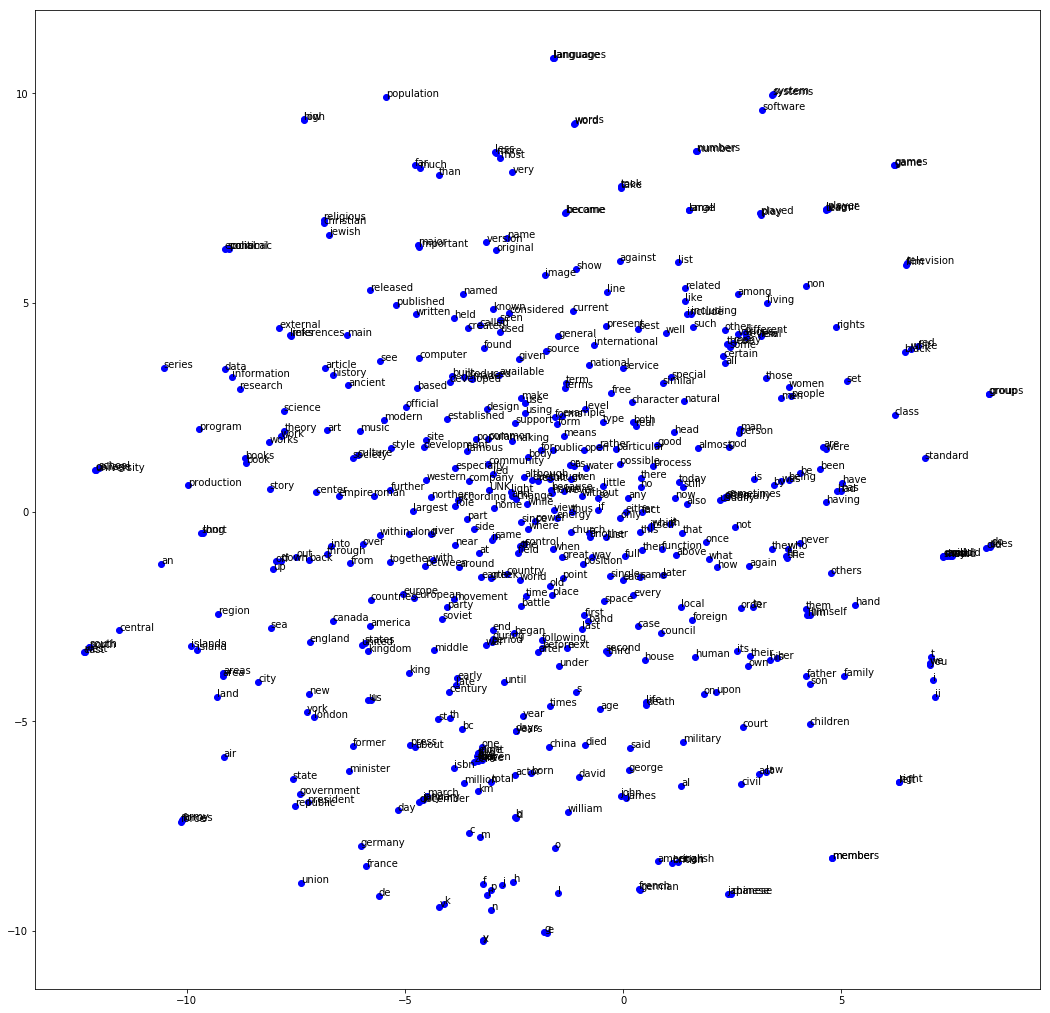

In [20]:
plt.figure(figsize=(18, 18))  # in inches
for index, word in enumerate(words_to_plot):
    x, y = low_dim_embs[index, :]
    plt.scatter(x, y, color='b')
    plt.annotate(word, xy=(x, y))
plt.show()